# A/B testing analysis
by *Chezi Mana*

# Introduction
A previous analyst has launched an A/B test for for a new recommendation system for an international online store.<br>
Then one clear day, *he decided to quit and start a watermelon farm in brazil*.<br>
And here we are picking up the pieces and analyzing the test(s).

# Goal: Analyze the A/B tests results for implementing a recommendation system

## Technical description

- **Test name:** recommender_system_test.
- **Groups:** А (control), B (new payment funnel).
- **Launch date:** 2020-12-07.
- **Date when they stopped taking up new users:** 2020-12-21.
- **End date:** 2021-01-01.
- **Audience:** 15% of the new users from the EU region.
- **Purpose of the test:** Testing changes related to the introduction of an improved recommendation system.
- **Expected result:** Within 14 days of signing up, users will show better conversion into:
    - product page views (product_page event).
    - instances of adding items to the shopping cart (product_cart).
    - and purchases (purchase).<br>
    At each stage of the funnel product_page → product_cart → purchase, **there will be at least a 10% increase.**
- **Expected number of test participants:** 6000

---
<a id="table"></a>

#  Table of Contents

- [Importing libraries and data](#import)
- [EDA - A look at the data](#EDA)
    - [Calendar table](#calendar)
    - [Users table](#users)
        - [Basics](#userbsics)
        - [Describe](#describe)
        - [Duplicates and missing values](#misslicate)
        - [Devices and regions](#devigions)
        - [Daily user signups](#dailysign)
    - [Events table](#events)
        - [Basics](#evbasics)
        - [Duplicates and missing values](#evdups&missing)
        - [More purchases than cart](#morepurch)
        - [Total revenue / puchase amount](#evrev)
        - [Event and user frequencies](#eventfreq)
        - [Event per user](#eventuser)
        - [Daily events count](#dailyvents)
    - [Tests table](#tests)
        - [Basics](#tesbasics)
        - [Duplicates and missing values](#tesdups)
        - [There are two tests](#twotests)
        - [Mixed users between groups](#doubleusers)
            - [Removing mixed users](#removingdoubles)
        - [Splitting and merging to test tables](#creation)
    - [EDA conclusions](#EDAconc)
- [Recommendation system analisys](#recanal)
    - [Basics](#recbasics)
    - [Where are users from?](#recwherefrom)
        - [Removing non EU users](#recforeigners)
    - [Daily signup group ratio](#recsignup)
    - [Devices used](#recdevices)
    - [Removing Dec-30 user](#rec30rem)
    - [Users daily traffic](#recuserfreq)
    - [Group purchase behaviour](#recgrouprate)
    - [Events distribution](#receventdist)
        - [Group Distribution](#receventdist)
        - [Daily distribution](#recdailyuserlogs)
    - [Event statistical difference](#recstatis)
- [A peek into interface test](#interpeek)
    - [Daily signup / group percentage](#interpeek)
    - [Event funnel](#inteventfun)
    - [Event statistical difference](#intest)
    - [Interface test conclusions](#intconc)
- [What is wrong with the test?](#whatswrong)
- [Summary and conclusions](#overallsum)

--- 

<a id="import"></a>

## Import libraries and reading data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

import math as mth
from scipy import stats as st

In [2]:
#reading the files with relevant date parsing and categorical column as category dtype
calendar = pd.read_csv('ab_project_marketing_events.csv', parse_dates = ['start_dt', 'finish_dt'])
users = pd.read_csv('final_ab_new_users_upd.csv', parse_dates = ['first_date'])#, dtype = {'region' : 'category', 'device' : 'category'})
events = pd.read_csv('final_ab_events_us.csv', parse_dates = ['event_dt'])#, dtype = {'details' : 'category'})
tests = pd.read_csv('final_ab_participants_upd.csv')

---
[Back to table of contents](#table) 
<a id="EDA"></a>

## EDA - A look at the data

---
[Back to table of contents](#table) <a id="calendar"></a>

### calendar:
This is just calendar of marketing events for 2020 per region.
- columns:
    - name — the name of the marketing event
    - regions — regions where the ad campaign will be held
    - start_dt — campaign start date
    - finish_dt — campaign end date

In [3]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [4]:
calendar.sort_values('start_dt')

name                   regions   start_dt  \
6             Chinese New Year Promo                      APAC 2020-01-25   
1       St. Valentine's Day Giveaway  EU, CIS, APAC, N.America 2020-02-14   
8    International Women's Day Promo             EU, CIS, APAC 2020-03-08   
2             St. Patric's Day Promo             EU, N.America 2020-03-17   
3                       Easter Promo  EU, CIS, APAC, N.America 2020-04-12   
7   Labor day (May 1st) Ads Campaign             EU, CIS, APAC 2020-05-01   
9    Victory Day CIS (May 9th) Event                       CIS 2020-05-09   
11     Dragon Boat Festival Giveaway                      APAC 2020-06-25   
4                  4th of July Promo                 N.America 2020-07-04   
13             Chinese Moon Festival                      APAC 2020-10-01   
12           Single's Day Gift Promo                      APAC 2020-11-11   
5          Black Friday Ads Campaign  EU, CIS, APAC, N.America 2020-11-26   
0           Christmas&New Year Promo             EU, N.America 2020-12-25   
10         CIS New Year Gift Lottery                       CIS 2020-12-30   

    finish_dt  
6  2020-02-07  
1  2020-02-16  
8  2020-03-10  
2  2020-03-19  
3  2020-04-19  
7  2020-05-03  
9  2020-05-11  
11 2020-07-01  
4  2020-07-11  
13 2020-10-07  
12 2020-11-12  
5  2020-12-01  
0  2021-01-03  
10 2021-01-07

#### Christmas&New Year Promo (in EU and N.America), and CIS New Year Gift Lottery (in CIS), took place at the time of the test.
This may affect and distort user behaviour at the dates: Dec25, and Dec30.<br>
maybe the tests should have taken place another time where there are no special events and holidays.

- [Back to table of contents](#table) <a id="users"></a>
---

### users
All users who signed up from Dec7 to Dec21, 2020.

- columns:
    - user_id.
    - first_date — sign-up date.
    - region.
    - device — device used to sign up.

[Back to table of contents](#table) 
<a id="userbsics"></a>

---

#### basics

In [5]:
users.sample(3)

user_id first_date     region   device
46195  03B5DDFF7919A1C5 2020-12-12         EU       PC
39746  506BB3A259BA94B1 2020-12-11  N.America  Android
30798  86044E2606612B14 2020-12-23         EU  Android

In [6]:
users.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 11.4 MB


<a id="describe"></a>
[Back to table of contents](#table) 

---

#### Using describe() we can already see some users have signed up after the test was stopped

In [7]:
users.describe()

<ipython-input-7-a2e183d0d39d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  users.describe()


user_id           first_date region   device
count              58703                58703  58703    58703
unique             58703                   17      4        4
top     D72A72121175D8BE  2020-12-21 00:00:00     EU  Android
freq                   1                 6077  43396    26159
first                NaN  2020-12-07 00:00:00    NaN      NaN
last                 NaN  2020-12-23 00:00:00    NaN      NaN

**Note that registration of new users ended on 2020-12-23, but according to the data information, the registrations of new users should end on 2020-12-21.**

<a id="misslicate"></a>
[Back to table of contents](#table) 

---

#### There are no duplicates or missing values

In [8]:
users.duplicated().sum()

0

In [9]:
users.isnull().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

<a id="devigions"></a>
[Back to table of contents](#table) 

---

#### Region and Device columns

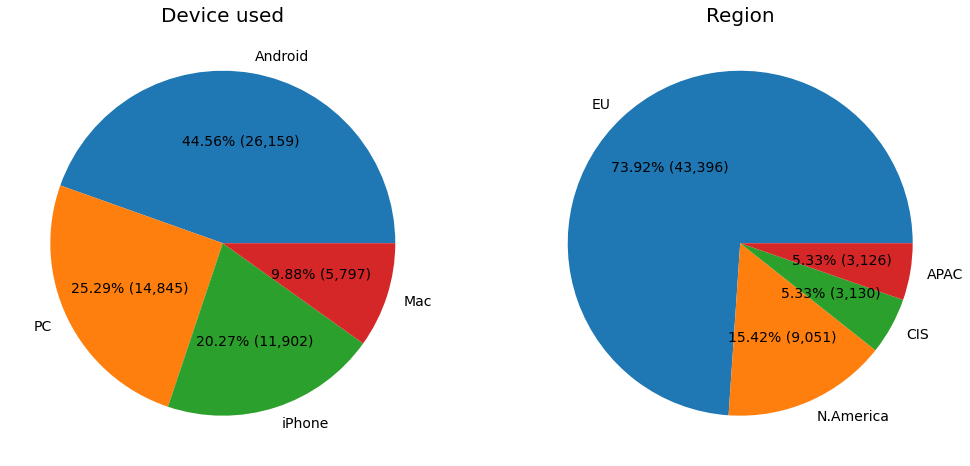

'Device:'

Android    26159
PC         14845
iPhone     11902
Mac         5797
Name: device, dtype: int64

'Region:'

EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: region, dtype: int64

In [10]:
#displayed as pie:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17, 17)) 
ax1.pie(
        users['device'].value_counts(), labels = users['device'].value_counts().index.tolist(),
        autopct = lambda x : '{:.2f}% ({:,.0f})'.format(x,x * sum(users['device'].value_counts()/100)),
        textprops={'color' : 'k', 'fontsize': 14}
        )
ax1.set_title('Device used', fontsize = 20)

ax2.pie(
    users['region'].value_counts(), labels = users['region'].value_counts().index.tolist(),
    autopct = lambda x : '{:.2f}% ({:,.0f})'.format(x,x * sum(users['region'].value_counts()/100)),
    textprops={'color' : 'k', 'fontsize': 14}
    )
ax2.set_title('Region', fontsize = 20)
plt.show()

#and text:
display('Device:', users['device'].value_counts())
display('Region:', users['region'].value_counts())

##### 74% users are from Europe, and 44%  devices used are  Android.

<a id="dailysign"></a>
[Back to table of contents](#table) 

---

#### Daily user sign-ups

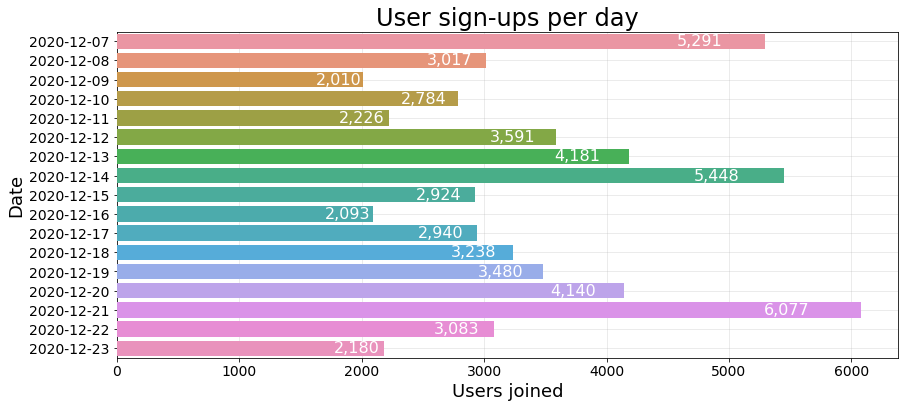

58703 users signed up in total.
53440 users signed up between Dec07 and Dec21.
5263 users signed up on Dec22-23, Two days after the signup phase ended.
6077 users signed up on Dec21, which is the largest amount of signups


In [11]:
plt.figure(figsize = (14,6))
usersdate = sns.barplot(data = users['first_date'].value_counts().sort_index().reset_index(), zorder = 3, y = 'index', x = 'first_date')
usersdate.tick_params(axis='both', which='major', labelsize=14)
usersdate.set_yticklabels(users["first_date"].sort_values().map(pd.Timestamp.date).unique())
usersdate.set_title('User sign-ups per day', size = 24)
usersdate.set_ylabel('Date', size = 18)
usersdate.set_xlabel('Users joined', size = 18)
usersdate.grid(alpha = 0.3)
for bar in usersdate.patches:
    plt.text((bar.get_width() * 0.9), bar.get_y() + (bar.get_height() / 2), '{:,}'.format(int(bar.get_width())),
             ha='center', va='center', fontsize = 16, color = 'w')
plt.show()

print('{} users signed up in total.'.format(users['user_id'].nunique()))
print('{} users signed up between Dec07 and Dec21.'.format(users[users['first_date'] <= '2020-12-21']['user_id'].count()))
print('{} users signed up on Dec22-23, Two days after the signup phase ended.'
                      .format(users[users['first_date'] > '2020-12-21']['user_id'].count()))
print('{} users signed up on Dec21, which is the largest amount of signups'.format(users[users['first_date'] == '2020-12-21']['user_id'].count()))

<a id="added_comment"></a>

---

##### We can see that:
- the test ended it's sign ups on Dec21. 5,263 users who signed up at Dec22 and Dec23.
    - However the test itself ended about a week later, on Jan 1st.
- The day with the most sign-ups is Dec21. this is the last day of the enlistment of users to the recommender system test.
- The second day with most sign-ups is Dec07, this is the day test started gathering users.
- All three days with most signups(7th, 14th, and 21st) are sundays.
- There are 58,703 sign-ups in total.
- There are 2 extra days of user sign-ups after the enlistment has ended.
- The 3 days with most signups are EXACTLY 7 days appart, this shows a weekly cycle with monday being the strongest day, and wednesday being the weakest.

<a id="events"></a>
[Back to table of contents](#table) 

---

### events
Events of the new users within the testing period from December 7, 2020 through January 1, 2021
- columns:
    - user_id
    - event_dt — event date and time
    - event_name — event type name
    - details — additional data on the event (for instance, the order total in USD for purchase events)

<a id="evbasics"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### basics

In [12]:
events.sample(3)

user_id            event_dt    event_name  details
202536  2029EA40AFA27E30 2020-12-21 22:36:12  product_page      NaN
101399  007D97CD7C272861 2020-12-21 11:25:28  product_cart      NaN
13838   9316B239FAB5707A 2020-12-13 01:27:17      purchase     4.99

In [13]:
events.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 62.4 MB


In [14]:
events.describe(include = 'all')

<ipython-input-14-e15f3db10e1a>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  events.describe(include = 'all')


user_id             event_dt event_name       details
count             423761               423761     423761  60314.000000
unique             58703               257138          4           NaN
top     A3917F81482141F2  2020-12-14 18:54:55      login           NaN
freq                  36                   10     182465           NaN
first                NaN  2020-12-07 00:00:33        NaN           NaN
last                 NaN  2020-12-30 23:36:33        NaN           NaN
mean                 NaN                  NaN        NaN     23.881219
std                  NaN                  NaN        NaN     72.228884
min                  NaN                  NaN        NaN      4.990000
25%                  NaN                  NaN        NaN      4.990000
50%                  NaN                  NaN        NaN      4.990000
75%                  NaN                  NaN        NaN      9.990000
max                  NaN                  NaN        NaN    499.990000

<a id="evdups&missing"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### There are no duplicates

In [15]:
events.duplicated().sum()

0

#### There are 363,447 missing values in the details column

In [16]:
events.isnull().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

In [17]:
events['details'].value_counts(dropna = False)

NaN       363447
4.99       44579
9.99        9158
99.99       5405
499.99      1172
Name: details, dtype: int64

In [18]:
(events[events['details'].isnull()]['event_name'] == 'purchase').value_counts()

False    363447
Name: event_name, dtype: int64

In [19]:
#value counts for all rows in details column except those with purchase in event name:
events.query('event_name != "purchase"')['details'].value_counts(dropna = False)

NaN    363447
Name: details, dtype: int64

##### As we can see, the values in details have prices for the 'purchase' event, and all other rows besides the purchase events have missing values since there was no purchase.

<a id="morepurch"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### There are a few more purchase events than product_cart

In [20]:
events['event_name'].value_counts()

login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: event_name, dtype: int64

##### This probably means the product cart is optional, yet barely any users skipped it
- Maybe only one group of users had this option.
- Maybe it is due to users going back and forth to cart.

<a id="evrev"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### checking revenue from total purchases

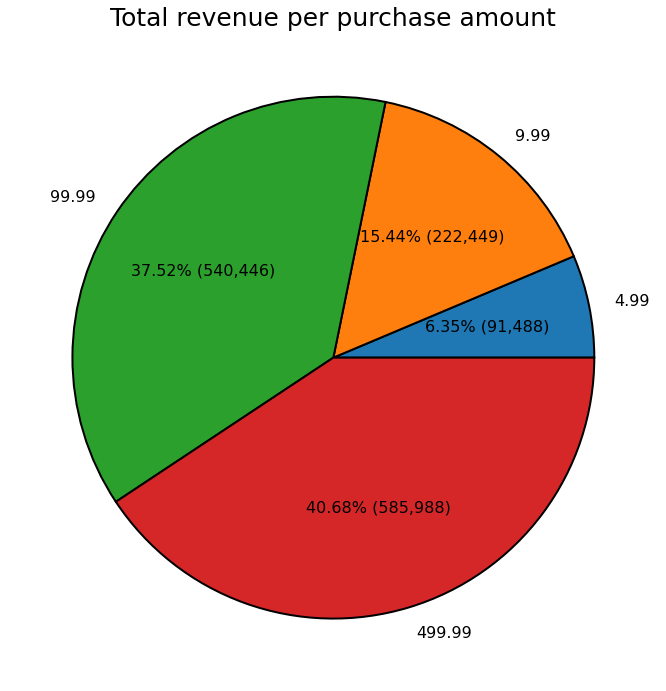

In [21]:
t_rev = events['details'].value_counts().reset_index()
t_rev['total'] = t_rev['index'].astype('float') * t_rev['details'].astype('float')

plt.figure(figsize = (12,12))
plt.pie(t_rev['total'].sort_values(), labels = t_rev['index'],
        autopct = lambda x : '{:.2f}% ({:,.0f})'.format(x,x * sum(t_rev['total'])/100),
        wedgeprops={"edgecolor" : "k", 'linewidth' : 2}, textprops={'color' : 'k', 'fontsize': 16}
       )
plt.title('Total revenue per purchase amount', size = 25)
plt.show()

#t_rev.sort_values('total', ascending = False)

##### We can see that most purchases by far are of 4.99. however if we sum the revenue by  each price. purchases of 499.99 take a much bigger portion of the total revenue.

<a id="eventfreq"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### What are the events and user frequencies?

In [22]:
events_count = events.groupby('event_name')['user_id'].count().reset_index().rename(columns = {'user_id':'events_count'},
    index = {2:1,1:2}).sort_index() #sorting by custom indexing so purchase will show last
events_users = events.groupby('event_name')['user_id'].nunique().reset_index().rename(columns = {'user_id':'events_users'},
    index = {2:1,1:2}).sort_index() #sorting by custom indexing so purchase will show last

colors = ["#CDE9D6", "#D299FD", "#FFF1CB", "#F8D3CF"]

fig = go.Figure()
fig.add_trace(go.Funnel(marker = {"color": colors}, name = 'Group A', y = events_count['event_name'], x = events_count['events_count'],#text=events_count['event_name'],
             text = events_count['event_name'], textinfo = 'text + value + percent initial', textposition = 'inside'))
fig.update_layout(title={'text': "Event frequency", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis_title='Events frequency', yaxis_title= 'Event screen', font=dict(size=14))
fig.update_yaxes(showticklabels=False)
fig.show()

fig = go.Figure()
fig.add_trace(go.Funnel(marker = {"color": colors}, name = 'Group A', y = events_users['event_name'], x = events_users['events_users'],#text=events_count['event_name'],
             text = events_count['event_name'], textinfo = 'text + value + percent initial', textposition = 'inside'))
fig.update_layout(title={'text': "User frequency", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis_title='Events frequency', yaxis_title= 'Event screen', font=dict(size=14))
fig.update_yaxes(showticklabels=False)
fig.show()

##### Both frequency funnels are similar in proportions between the events:
- About a third of the login events proceeded to the product page.
- 50% of the product page events continued to purchase.
- We already saw that there are more purchase events than product_cart and assumed it is because users go back and forth to cart or that cart is optional but only few users skipped it (maybe only one group could skip it).

<a id="eventuser"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

### Events per user

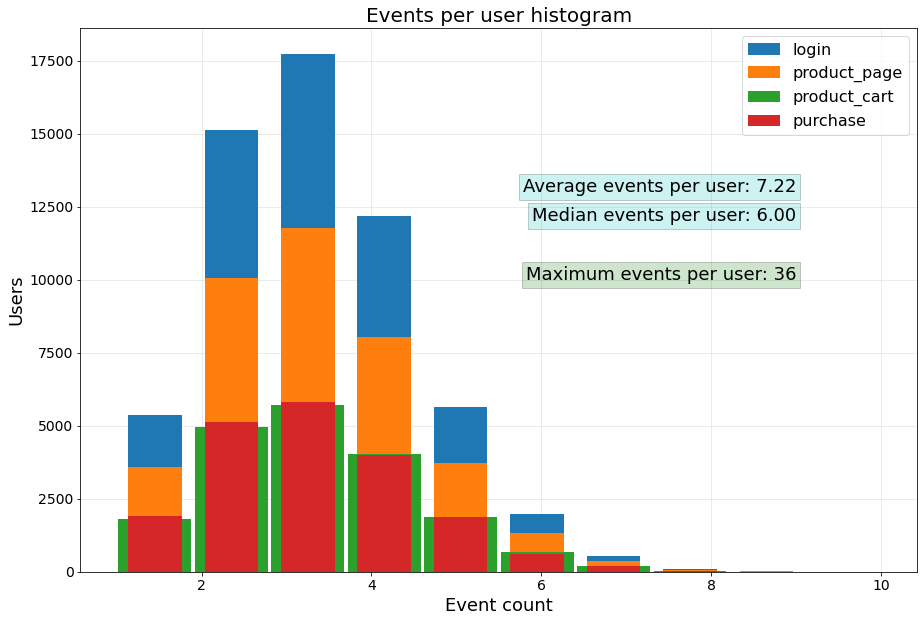

In [23]:
#events per user histogram:
plt.figure(figsize = (15,10))

#slicing and drawing histogram for counts of each event per user:
events.query('event_name == "login"').groupby('user_id')['event_name'].count().hist(
    label = 'login', rwidth = 0.7, zorder = 3)
events.query('event_name == "product_page"').groupby('user_id')['event_name'].count().hist(
    label = 'product_page', rwidth = 0.7, zorder = 3)
events.query('event_name == "product_cart"').groupby('user_id')['event_name'].count().hist(
    label = 'product_cart', rwidth = 0.95, zorder = 3)
events.query('event_name == "purchase"').groupby('user_id')['event_name'].count().hist(
    label = 'purchase', rwidth = 0.7, zorder = 3)

#fixing some aesthetics:
plt.title('Events per user histogram', fontsize = 20)
plt.xlabel('Event count', fontsize = 18)
plt.ylabel('Users', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(alpha = 0.3)

#adding info text:
plt.text(9, 13000, 'Average events per user: {:.2f}'.format(events.groupby(['user_id'])['event_name'].count().mean()),
         bbox = dict(facecolor = 'c', alpha = 0.2), size = 18, ha = 'right')
plt.text(9, 12000, 'Median events per user: {:.2f}'.format(events.groupby(['user_id'])['event_name'].count().median()),
         bbox = dict(facecolor = 'c', alpha = 0.2), size = 18, ha = 'right')
plt.text(9, 10000, 'Maximum events per user: {}'.format(events.groupby(['user_id'])['event_name'].count().max()),
         bbox = dict(facecolor = 'g', alpha = 0.2), size = 18, ha = 'right')
plt.legend(fontsize = 16)

plt.show()

##### Events per user stats
Between everyone, those who purchased, and those who didn't.

In [24]:
#some stats for total event count of users who purchased vs those who didn't
purcahsed_users = events[events['event_name'] == "purchase"]['user_id'].unique().tolist()
eventstats = pd.concat([#show different stats about:
    events[~events['user_id'].isin(purcahsed_users)] #not purchased
        .groupby('user_id')['event_name'].count().agg(['count', 'min', 'max', 'std', 'mean', 'median']), #not purchased
    events[events['user_id'].isin(purcahsed_users)] #purchased
        .groupby('user_id')['event_name'].count().agg(['count', 'min', 'max', 'std', 'mean', 'median']), #purchased
    events.groupby('user_id')['event_name'].count().agg(['count', 'min', 'max', 'std', 'mean', 'median'])],  #everyone
    axis = 1)
eventstats.columns = ['not_purchased', 'purchased', 'everyone']#rename columns
print('Total events per user, purchased versus not purchased:')
eventstats

Total events per user, purchased versus not purchased:


not_purchased     purchased      everyone
count    39135.000000  19568.000000  58703.000000
min          1.000000      1.000000      1.000000
max         27.000000     36.000000     36.000000
std          3.447088      4.551734      4.122609
mean         6.177463      9.301206      7.218728
median       6.000000      9.000000      6.000000

In [25]:
#counting events number for each user who made a purchase:
(events[events['user_id'].isin(purcahsed_users)].groupby('user_id')['event_name'].count().value_counts()).sort_index().head(5)

1       7
2     398
3    1099
4    1418
5      68
Name: event_name, dtype: int64

##### The average user has 7.22 events in total.
- Most users log 6 events.
- Those who make a purchase log on average twice or three more times than those who don't (could be the cart and purchase events).
- We already know that purchase and cart events are similar in frequency.
- There are users who had only one or two event counts, yet still they managed to purchase. Either it's a VERY fast "buy now" purchase option, or there's a problem in the system.
    - 7 users only saw one event page. (!?)
    - 398 users saw two pages.

<a id="dailyvents"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### Daily event count

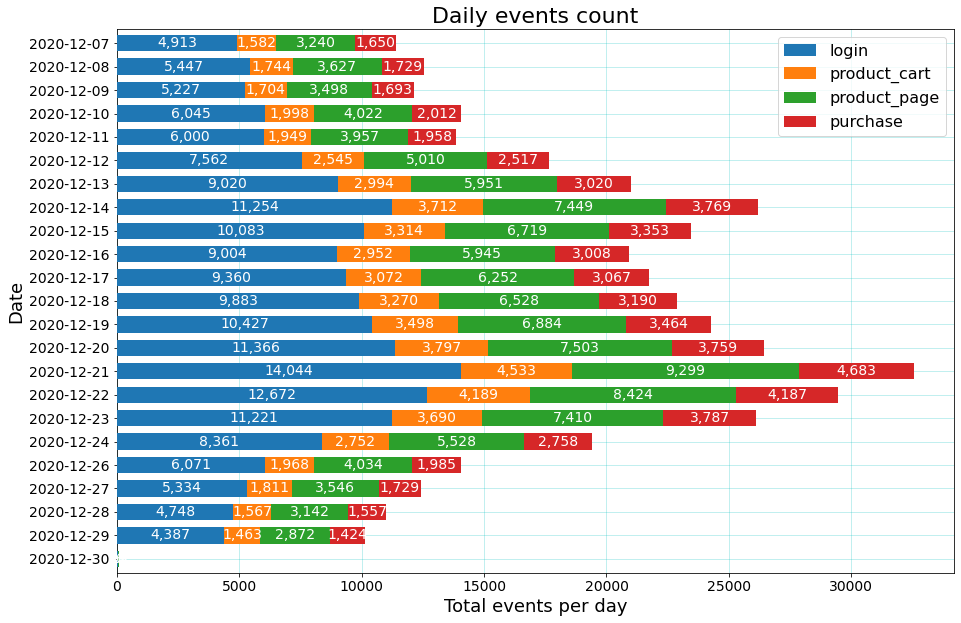

In [26]:
#creating table and drawing graph on daily events count:
user_daily_events = events.pivot_table(index = (events['event_dt'].dt.date), columns = 'event_name', values = 'user_id', aggfunc = 'count'
                        ).sort_index(ascending = False).plot(kind = 'barh', width = 0.7, stacked = True, figsize = (15, 10), zorder = 3)
user_daily_events.grid(alpha = 0.4, c = 'c')
user_daily_events.legend(fontsize = 15)
user_daily_events.set_title('Daily events count', size = 22)
user_daily_events.tick_params(axis='both', which='major', labelsize=14)
user_daily_events.set_ylabel('Date', size = 18)
user_daily_events.set_xlabel('Total events per day', size = 18)
user_daily_events.grid(alpha = 0.3)
user_daily_events.legend(fontsize=16)

for bar in user_daily_events.patches:
    plt.text((bar.get_x()+ (bar.get_width() /2)), bar.get_y() + (bar.get_height() / 2), '{:,}'.format(int(bar.get_width())),
             ha='center', va='center', fontsize = 14, color = 'w')
plt.show()

##### The events for each day are similar in proportions.
- There are only 2 events logged on Dec 30.
- In the first week There are 10,000 to 22,000 events. Scaling up gradually over the days, although a small halt happened on Dec 11.
- After a peak and small decline on Dec 14, the incline keeps scaling until Dec 21, the day with most events (34,000). This is also the day when they stopped adding more users to the test.
- After the 21st, there's a strong decline, in Dec 29 there are only 10,000 events, this is less than the first day.
- There is also only one user who logged in twice on Dec30, these logs will be removed in the future.

<a id="tests"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

### tests: this is a table containing test groups, name, and participants
- columns:
    - user_id
    - ab_test — test name
    - group — the test group the user belonged to

<a id="tesbasics"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### basics

In [27]:
tests.shape

(14525, 3)

In [28]:
tests.sample(3)

user_id group                  ab_test
3779  594E2EA1A3218BB4     B        interface_eu_test
782   A7EE379599B38AE0     A  recommender_system_test
9433  1F248324529E4E85     B        interface_eu_test

In [29]:
tests.describe()

user_id  group            ab_test
count              14525  14525              14525
unique             13638      2                  2
top     307C06C0E6F09B93      A  interface_eu_test
freq                   2   8214              10850

In [30]:
tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [31]:
tests.isnull().sum()

user_id    0
group      0
ab_test    0
dtype: int64

<a id="tesdups"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

In [32]:
tests.duplicated().sum()

0

##### So far, no missing values, no duplicates, structure looks well!.
However......

<a id="twotests"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

In [33]:
tests['ab_test'].value_counts()

interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

#### There seem to be two tests done:
1. "recommender_system_test"
    - Has total of 10850 users.
        - 2,747 users in group A
        - 928 users in group B
2. "interface_eu_test"
    - Has total of 10,850 users.
        - 5,467 users in group A
        - 5,383 users in group B

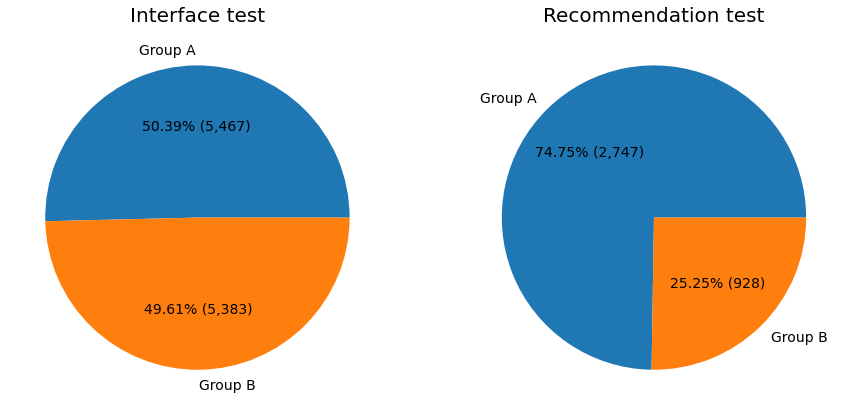

In [34]:
#splitting the data into different tests and sum up group users
intsum = tests[tests['ab_test'] == "interface_eu_test"].groupby('group')['user_id'].nunique().reset_index()
recsum = tests[tests['ab_test'] == "recommender_system_test"].groupby('group')['user_id'].nunique().reset_index()

#drawing pies to chcek the balance of users between groups:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 15))
ax1.pie(
        intsum['user_id'], labels = 'Group ' + intsum['group'],
         autopct = lambda x : '{:.2f}% ({:,.0f})'.format(x, x * sum(intsum['user_id']/100)),
         textprops={'color' : 'k', 'fontsize': 14}
        )
ax1.set_title('Interface test', fontsize = 20)


ax2.pie(
        recsum['user_id'], labels = 'Group ' + recsum['group'],
         autopct = lambda x : '{:.2f}% ({:,.0f})'.format(x, x * sum(recsum['user_id']/100)),
         textprops={'color' : 'k', 'fontsize': 14}
        )

ax2.set_title('Recommendation test', fontsize = 20)
plt.show()


##### problem:
- The interface test groups are pretty equal in size (50.39% and 49.61% of the total users).
- The recommendation test groups are not.
    - Group A has 2747 users, and is 74.75% of the total users.
    - Group B has 928 users, and is 25.25% of the total users.<br>
    - There are not many users to begin with, especially after splitting the groups.
    - The groups are not equal in their size, since we will use a z-test which is a test of proportions, it's ok.

<a id="doubleusers"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### Further investigation
**Are there users in more than just one group?**

In [35]:
#splitting both test users into groups A and B:
Arec = tests[(tests['group'] == "A") & (tests['ab_test'] == "recommender_system_test")]['user_id'].tolist()
Brec = tests[(tests['group'] == "B") & (tests['ab_test'] == "recommender_system_test")]['user_id'].tolist()
Aint = tests[(tests['group'] == "A") & (tests['ab_test'] == "interface_eu_test")]['user_id'].tolist()
Bint = tests[(tests['group'] == "B") & (tests['ab_test'] == "interface_eu_test")]['user_id'].tolist()


#recommendation test total users:
print('- In the recommender test there are {} users. \n   {} in group A and {} in group B.'.format(
    len(Arec+Brec), len(Arec), len(Brec)))
print('   There are {} users on Both groups in the reccommender system test'.format(len([x for x in Aint if x in Bint])))

print()
#interface test total users:
print('- In the interface test there are {} users. \n   {} in group A and {} in group B.'.format(
    len(Aint+Bint), len(Aint), len(Bint)))
print('   There are {} users on Both groups in the interface test'.format(len([x for x in Arec if x in Brec])))

#finding double users who are in mixed groups:    (will also be used to remove users)
bothA = [x for x in Aint if x in Arec]
bothB = [x for x in Brec if x in Bint]
Brec_Aint = [x for x in Brec if x in Aint]
Arec_Bint = [x for x in Arec if x in Bint]

#printing the numbers:
print('\n- There are {} users who were assigned to group B in both tests at the same time.'.format(
    len(bothB)))
#B in recommendation and A in interface
print('- There are {} users who were assigned to group B in the recommender system test,'.format(
    len(Brec_Aint)),'\n   and also assigned to group A in the interface test at the same time.')
#B in interface and A in recommendation
print('- There are {} users who were assigned to group A in the recommender system test,'.format(
    len(Arec_Bint)),'\n   and also assigned to group B in the interface test at the same time.')

- In the recommender test there are 3675 users. 
   2747 in group A and 928 in group B.
   There are 0 users on Both groups in the reccommender system test

- In the interface test there are 10850 users. 
   5467 in group A and 5383 in group B.
   There are 0 users on Both groups in the interface test

- There are 106 users who were assigned to group B in both tests at the same time.
- There are 116 users who were assigned to group B in the recommender system test, 
   and also assigned to group A in the interface test at the same time.
- There are 325 users who were assigned to group A in the recommender system test, 
   and also assigned to group B in the interface test at the same time.


##### Although the users of each test did not mix in both groups A or B, THEY DID MIX between the tests.
Any user who took part in group B for either test, has been exposed to changes in the regular use of the system. therefore this user must participate in group B of only one of the tests.<br>
In other words, we must remove any user has participated in more than one group, except users who were in group A on both tests, since they have seen no changes at all and therefore their behaviour has not changed.

<a id="removingdoubles"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### Removing the double users
Since the group numbers are not euqual in the first place, we can keep users who were both in A groups without worrying (any more than we are already worried) about changes in relative difference between the groups.

In [36]:
#creating a bad users list from the previous definitions:
bad_users = bothB + Brec_Aint + Arec_Bint 

print('The tests table has {:,} users.'
                                      .format(tests['user_id'].nunique()))
print('There are {} - {:.2%} users who participate in mixed group that has to be removed.'
     .format(len(bad_users), (len(bad_users) / tests['user_id'].nunique())))

The tests table has 13,638 users.
There are 547 - 4.01% users who participate in mixed group that has to be removed.


In [37]:
#removing double users from the data:
tests = tests[~tests['user_id'].isin(bad_users)]
print('After cleaning,The tests table now has {:,} users.'.format(tests['user_id'].nunique()))

After cleaning,The tests table now has 13,091 users.


<a id="creation"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

#### Finally making a clean table with all the data for each of the tests

In [38]:
#creating a clean table for each test:
recommend = (
    tests[tests['ab_test'] == 'recommender_system_test']
        .merge(events, how = 'inner', on = 'user_id')
            .merge(users, how = 'inner', on = 'user_id')
                ).drop('ab_test', axis = 1)

interface = (
    tests[tests['ab_test'] == 'interface_eu_test']
        .merge(events, how = 'inner', on = 'user_id')
            .merge(users, how = 'inner', on = 'user_id')
                ).drop('ab_test', axis = 1)

display(recommend.sample(3))
display(interface.sample(3))

user_id group            event_dt    event_name  details  \
19503  AC8A411A22EAA8D8     A 2020-12-20 02:10:59  product_cart      NaN   
7307   991220A6485D2BA1     A 2020-12-20 21:10:37      purchase    99.99   
1481   A5C73A9B0E44E70F     A 2020-12-18 18:42:23  product_page      NaN   

      first_date region   device  
19503 2020-12-17    CIS  Android  
7307  2020-12-19     EU       PC  
1481  2020-12-14     EU  Android

user_id group            event_dt    event_name  details  \
55321  2B723CB31A277934     B 2020-12-22 03:20:18      purchase    99.99   
7044   16FC265A9D773B65     B 2020-12-17 12:02:04      purchase     4.99   
11924  42BAD79F88B95B80     B 2020-12-17 07:28:30  product_page      NaN   

      first_date region   device  
55321 2020-12-20     EU      Mac  
7044  2020-12-17     EU  Android  
11924 2020-12-16     EU      Mac

<a id="EDAconc"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

### EDA Conclusions
#### Preprocessing
- No duplicates, all data types are correct after parsing them at the spot when read.
- There are two tests on the same users and database.<br>
we managed to create a clean table for each of the tests with the relevant users after merging the datasets and removing all the users who participated in more than one group for one test (other than A-A users, whom never seen changes and therefore their behaviour did not change),<br>this process included:
- Removing users from the tests table
- Slicing the tests table with each of the two tests. then merging the slices with the rest of the data (using inner merge- that way we can keep only the data that matches our clean slices)


#### General observations so far
- There we 2 promotions running during the tests - Christmas&New Year Promo (Dec-25 in EU and N.America), and CIS New Year Gift Lottery (Dec-30 in CIS).<br>
Such events can distort the test results.
- 74% users are from Europe and 44% of the devices used are Android, according to the users table.
- |the test ended it's sign ups on Dec21. 5,263 users who signed up at Dec22 and Dec23. However the test itself ended about a week later, on Jan 1st.
- The day with the most sign-ups is Dec21.<br>
The second day with most sign-ups is Dec07, this is interesting as the testing only begun that day.
- There are 58,703 sign-ups in total.
- most purchases are of 4.99. however if we sum the revenue by prices. purchases of 499.99 take a much bigger portion of the total revenue.
- about a third of the login events proceeded to the product page.
- 50% of the product page events continued to purchase.
- There must be a fast purchase option skipping the product_cart event, though not many users use it.

<a id="recanal"></a>
[Back to table of contents](#table) 

[Back to EDA](#EDA)

---

## Recommender system test analysis

<a id="recbasics"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

### Basic stuff:

In [39]:
recommend.sample(3)

user_id group            event_dt    event_name  details  \
17663  F1A94E1985108CF4     A 2020-12-20 11:02:03  product_page      NaN   
19910  1D573A1EC0A1DFB1     B 2020-12-19 18:54:06         login      NaN   
5634   ECFDC55465F7ED03     A 2020-12-15 14:40:52         login      NaN   

      first_date region   device  
17663 2020-12-19     EU  Android  
19910 2020-12-19    CIS       PC  
5634  2020-12-07     EU  Android

In [40]:
recommend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20526 entries, 0 to 20525
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     20526 non-null  object        
 1   group       20526 non-null  object        
 2   event_dt    20526 non-null  datetime64[ns]
 3   event_name  20526 non-null  object        
 4   details     2764 non-null   float64       
 5   first_date  20526 non-null  datetime64[ns]
 6   region      20526 non-null  object        
 7   device      20526 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 1.4+ MB


In [41]:
recommend.describe(include = 'all')

<ipython-input-41-58380c130360>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



user_id  group             event_dt event_name      details  \
count              20526  20526                20526      20526  2764.000000   
unique              3128      2                13712          4          NaN   
top     1198061F6AF34B7B      A  2020-12-17 20:13:22      login          NaN   
freq                  28  16547                    5       9270          NaN   
first                NaN    NaN  2020-12-07 00:16:00        NaN          NaN   
last                 NaN    NaN  2020-12-30 06:42:52        NaN          NaN   
mean                 NaN    NaN                  NaN        NaN    23.014602   
std                  NaN    NaN                  NaN        NaN    70.023300   
min                  NaN    NaN                  NaN        NaN     4.990000   
25%                  NaN    NaN                  NaN        NaN     4.990000   
50%                  NaN    NaN                  NaN        NaN     4.990000   
75%                  NaN    NaN                  NaN        NaN     9.990000   
max                  NaN    NaN                  NaN        NaN   499.990000   

                 first_date region   device  
count                 20526  20526    20526  
unique                   15      4        4  
top     2020-12-14 00:00:00     EU  Android  
freq                   2987  19291     9050  
first   2020-12-07 00:00:00    NaN      NaN  
last    2020-12-21 00:00:00    NaN      NaN  
mean                    NaN    NaN      NaN  
std                     NaN    NaN      NaN  
min                     NaN    NaN      NaN  
25%                     NaN    NaN      NaN  
50%                     NaN    NaN      NaN  
75%                     NaN    NaN      NaN  
max                     NaN    NaN      NaN

<a id="recwherefrom"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

### So where are they from?

In [42]:
print(recommend.groupby('region')['user_id'].nunique())
print('\nUsers not from EU: {}, this is {:.2%} of the users that has to be removed.'
      .format(recommend[recommend['region'] != "EU"]['user_id'].nunique(),
              recommend[recommend['region'] != "EU"]['user_id'].nunique() / recommend['user_id'].nunique()))

region
APAC           45
CIS            30
EU           2934
N.America     119
Name: user_id, dtype: int64

Users not from EU: 194, this is 6.20% of the users that has to be removed.


#### Surprise! some non EU users joined in the test whose audience is EU.
More processing needs to be done...  ok to work:
Since the test was on the EU region,  we want EU users only.

<a id="recforeigners"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

### Removing non EU users from the recommendation test table<br>And then removing the 'region' column.

In [43]:
recommend = recommend[recommend['region'] == 'EU']
recommend = recommend.drop('region', axis = 1)
recommend['user_id'].nunique()

2934

### How many users are left?

In [44]:
regroups = recommend.groupby('group')['user_id'].nunique()
print('There are total of {} users in the test, {} in group A, and {} in group B. Their ratio is {:.2%}'
                              .format(sum(regroups), regroups[0], regroups[1], regroups[1] / regroups[0]))

There are total of 2934 users in the test, 2279 in group A, and 655 in group B. Their ratio is 28.74%


#### There are 2934 users in total, group A with 655, and group B with 706 users.
In expectation, the test needed 6000 users. We need more test subjects!

<a id="audi"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

#### Speaking of expectations; The recommendation system tests expected 15% of the EU users to participate

In [45]:
totalusers = users[users['region'] == "EU"]['user_id'].nunique()
recomusers = tests[tests['ab_test'] == 'recommender_system_test']['user_id'].nunique()
recomusers_cleaned = recommend['user_id'].nunique()

print('The recommendation system test has {} users (before cleaning the data), out of {} EU users in the users data.'.format(recomusers, totalusers))
print('This is {:.2%} of the EU users, half of the expected audience of the test'.format(recomusers / totalusers))
print('After cleaning the data, there are {}({:.2%}) users in the test.'.format(recomusers_cleaned, recomusers_cleaned / totalusers))

The recommendation system test has 3128 users (before cleaning the data), out of 43396 EU users in the users data.
This is 7.21% of the EU users, half of the expected audience of the test
After cleaning the data, there are 2934(6.76%) users in the test.


##### Disappointment; There is not even half the expect amount of users in the test.

<a id="recsignup"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

### When did they sign up?

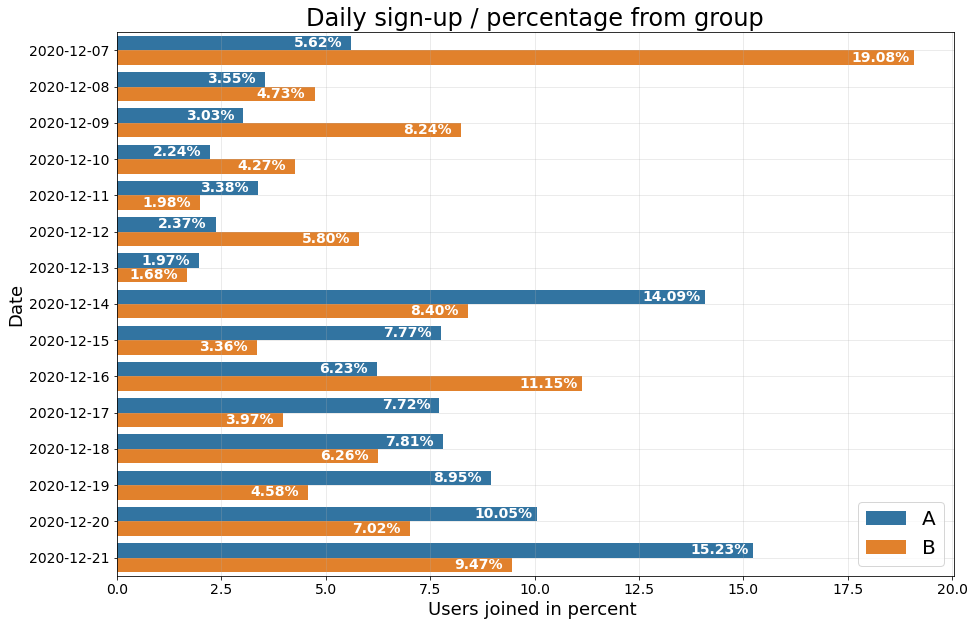

In [46]:
uspd = recommend.groupby(['first_date', 'group'])['user_id'].nunique().reset_index()
uspd['ratio'] = np.where(uspd['group'] == 'A', uspd['user_id'] / uspd[uspd['group'] == 'A']['user_id'].sum() * 100,
                                               uspd['user_id'] / uspd[uspd['group'] == 'B']['user_id'].sum() * 100)

plt.figure(figsize = (15,10))
uspdplot = sns.barplot(data = uspd, y = 'first_date', x = 'ratio', hue = 'group')
uspdplot.tick_params(axis='both', which='major', labelsize=14)
uspdplot.set_yticklabels(uspd["first_date"].sort_values().map(pd.Timestamp.date).unique())
uspdplot.set_title('Daily sign-up / percentage from group', size = 24)
uspdplot.set_ylabel('Date', size = 18)
uspdplot.set_xlabel('Users joined in percent ', size = 18)
uspdplot.grid(alpha = 0.3)
uspdplot.legend(fontsize=20)

for bar in uspdplot.patches:
    uspdplot.text((bar.get_width() - 0.8), bar.get_y() + (bar.get_height() / 2), '{:.2f}%'.format(bar.get_width()),
             ha='center', va='center', fontsize = 14, color = 'w', weight = 'bold')

#### Many of the users signed up on the second week of the signup period.
The ratio between the group sign-ups is very different. Not even one day with the same ratio of users signed up.<br>
Each day may impact the user behaviour differently, this is why it is important to recruit the same number of users, or at least the percentage of users if groups are not the same in size (like in our case).

<a id="recdevices"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

### What devices did they use?

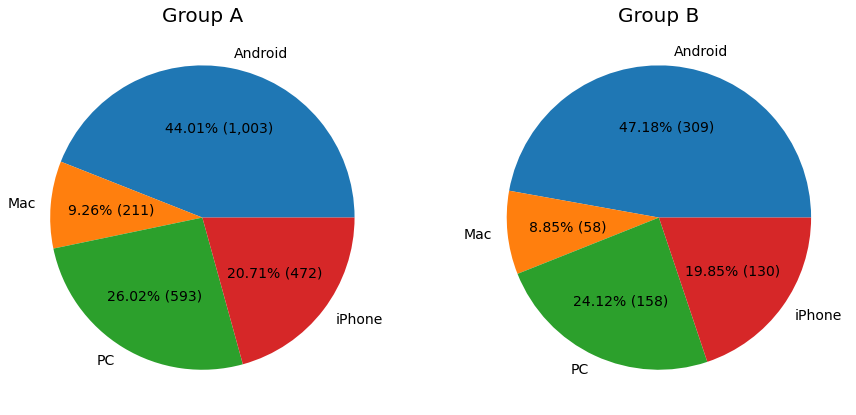

In [47]:
#creating table and group slices:
redevice = recommend.groupby(['device', 'group'])['user_id'].nunique().reset_index()
reAdevice = redevice[redevice['group'] == "A"]
reBdevice = redevice[redevice['group'] == "B"]

#making pies:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 15))
ax1.pie(
        reAdevice['user_id'], labels = reAdevice['device'],
         autopct = lambda x : '{:.2f}% ({:,.0f})'.format(x, x * sum(reAdevice['user_id']/100)),
         textprops={'color' : 'k', 'fontsize': 14}
        )
ax1.set_title('Group A', fontsize = 20)


ax2.pie(
        reBdevice['user_id'], labels = reBdevice['device'],
         autopct = lambda x : '{:.2f}% ({:,.0f})'.format(x, x * sum(reBdevice['user_id']/100)),
         textprops={'color' : 'k', 'fontsize': 14}
        )

ax2.set_title('Group B', fontsize = 20)
plt.show()

#redevice  

#### Devices used between the groups are similar in proportion
- Android is used by 44% and 47% of the users. Iphone and PC are about half of it (20% and 26%) and Mac has the smallest share of 9%.
- At least in devices, the ratio between the groups is equal.

<a id="rec30rem"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

### How often did users log in?
**notice:**
- Before we check the graph, on Dec 30 there was one user logging in, we will remove this day from the data of both the groupby and the main table it's taken from (recommend table)

In [48]:
reuse_daily = recommend.groupby([recommend['event_dt'].dt.date, 'group'])['user_id'].nunique().reset_index()
print('reuse_daily (one user on 30th):')
print(reuse_daily.tail(3))

#removing the only user who signed in at Dec30 from the reuse_daily groupby
reuse_daily = reuse_daily.drop(reuse_daily.tail(1).index)
print('None gone.')
print(reuse_daily.tail(2))

print('\nremoving this date from recommend main table too (only two events for the same user on this date):')
print(recommend[recommend['event_dt'] >= '2020-12-30'])
recommend = recommend[recommend['event_dt'] <= '2020-12-30']

reuse_daily (one user on 30th):
      event_dt group  user_id
42  2020-12-29     A      172
43  2020-12-29     B       26
44  2020-12-30     B        1
None gone.
      event_dt group  user_id
42  2020-12-29     A      172
43  2020-12-29     B       26

removing this date from recommend main table too (only two events for the same user on this date):
               user_id group            event_dt    event_name  details  \
3023  75845C83258FBF73     B 2020-12-30 06:42:52  product_cart      NaN   
3027  75845C83258FBF73     B 2020-12-30 06:42:52         login      NaN   

     first_date   device  
3023 2020-12-07  Android  
3027 2020-12-07  Android  


<a id="recuserfreq"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

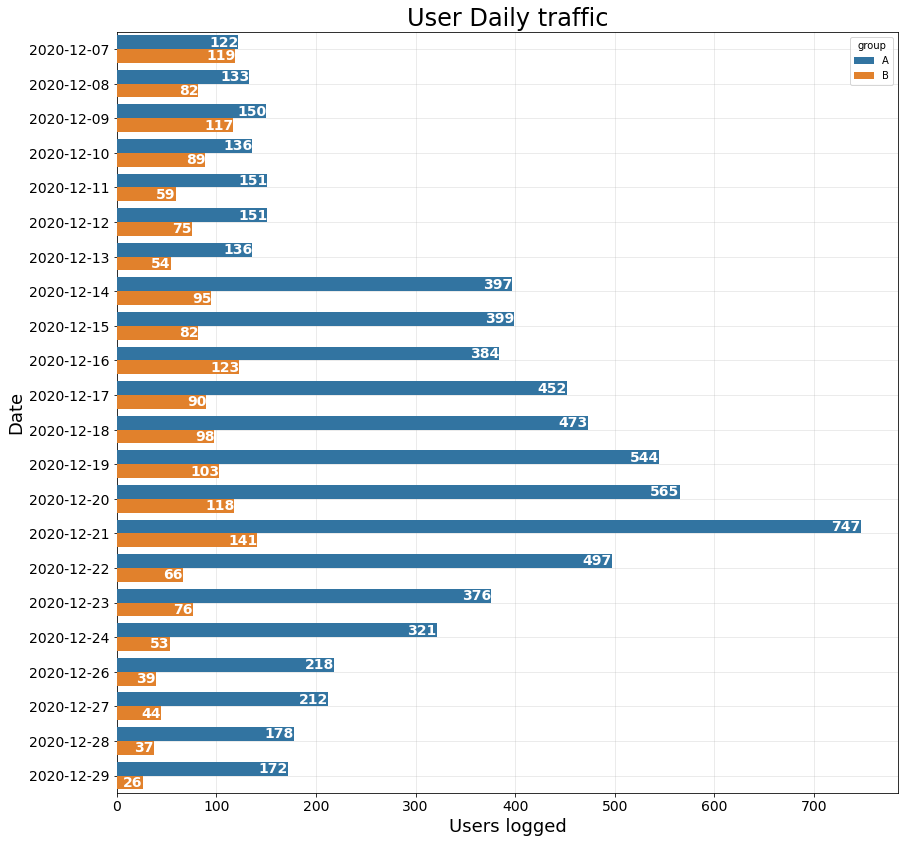

In [49]:
plt.figure(figsize = (14,14))
reuser_daily_plot = sns.barplot(data = reuse_daily, zorder = 3, y = 'event_dt', x = 'user_id', hue = 'group')
reuser_daily_plot.tick_params(axis='both', which='major', labelsize=14)
reuser_daily_plot.set_title('User Daily traffic', size = 24)
reuser_daily_plot.set_ylabel('Date', size = 18)
reuser_daily_plot.set_xlabel('Users logged', size = 18)
reuser_daily_plot.grid(alpha = 0.3)
for bar in reuser_daily_plot.patches:
    plt.text((bar.get_width()), bar.get_y() + (bar.get_height() / 2), '{}'.format(int(bar.get_width())),
             ha='right', va='center', fontsize = 14, c = 'w', weight = 'bold')
plt.show()

#### The day with the highest amount of  user activity on both groups for was on Dec 21st
- On Dec30, only 1 user logged in, this day was removed.
- Dec 21st was the last day of gathering users. This explains how in the beginning there are few events and the amount keeps growing until that date.
    - That day(21st) both groups had the highest user traffic:
        - Group A with 747 users.
        - Group B with 141.
    - And from 21st the traffic started to drop again.
        - Group B had only 26 users log-in on Dec 29th, and 1(who was removed) on 30th..!
        - Group A also had as few as 172 log-ins on Dec 29th, and none on the 30th..!
- Users stop using the service only after a few days. Lets hope they manage to place an order, and that's why they don't come back.
- The traffic of group A is greater since there are more users in this group.
    - On the first days Group B had a relatively higher number of logs than group A. After Dec-12 it reversed and the ratio of group A logs started growing higher.
- The traffic frequency, like most of the data, is very inconsistent.

<a id="recgrouprate"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

### So did they buy something or were they just "browsing"?<br>How long did it take to make a purchase?

In [50]:
#counting unique users who made at least one purchase from each group and then in total:
reApurch = recommend[(recommend['event_name'] == "purchase") & (recommend['group'] == "A")]['user_id'].nunique()
reBpurch = recommend[(recommend['event_name'] == "purchase") & (recommend['group'] == "B")]['user_id'].nunique()
reABpurch = reApurch + reBpurch

#counting total purchases from each group and then in total:
reAtot = recommend[(recommend['event_name'] == "purchase") & (recommend['group'] == "A")]['user_id'].count()
reBtot = recommend[(recommend['event_name'] == "purchase") & (recommend['group'] == "B")]['user_id'].count()
reABtot = reAtot + reBtot


print('A total of {} out of {} users ({:.2%}) made a purchase at least once.' # total unique purchases
      .format(reABpurch, recommend['user_id'].nunique(), reABpurch / recommend['user_id'].nunique()))

print('- In group A: {} users made a purchase with a {:.2%} purchase rate within the group.' #unique A
      .format(reApurch, reApurch / recommend[recommend['group'] == "A"]['user_id'].nunique()))
print('- In group B: {} users made a purchase with a {:.2%} purchase rate within the group.' #unique B
      .format(reBpurch, reBpurch / recommend[recommend['group'] == "B"]['user_id'].nunique()))

print('\nOverall, {} purchases were made by all users. \n- In group A: {} ({:.2%}).\n- In group B: {}({:.2%}).'
      .format(reABtot, #overall
              reAtot, reAtot / reABtot,  #total A
              reBtot, reBtot / reABtot)) #total B

A total of 925 out of 2934 users (31.53%) made a purchase at least once.
- In group A: 734 users made a purchase with a 32.21% purchase rate within the group.
- In group B: 191 users made a purchase with a 29.16% purchase rate within the group.

Overall, 2633 purchases were made by all users. 
- In group A: 2148 (81.58%).
- In group B: 485(18.42%).


#### Almost all users who did purchase, made it on their first day:

In [51]:
recommend['days_till_purchase'] = (recommend[recommend['event_name'] == 'purchase']['event_dt'] 
                                   - recommend[recommend['event_name'] == 'purchase']['first_date']).dt.days
recommend.groupby('user_id')['days_till_purchase'].min().value_counts().sort_index()

0.0    919
1.0      5
6.0      1
Name: days_till_purchase, dtype: int64

#### And then continued purchasing for up to 18 days later:

In [52]:
recommend['days_till_purchase'] = (recommend[recommend['event_name'] == 'purchase']['event_dt'] 
                                   - recommend[recommend['event_name'] == 'purchase']['first_date']).dt.days
recommend.groupby('user_id')['days_till_purchase'].max().value_counts().sort_index()

0.0     108
1.0     101
2.0      83
3.0      75
4.0      59
5.0      66
6.0      73
7.0      78
8.0      60
9.0      50
10.0     33
11.0     24
12.0     36
13.0     19
14.0     15
15.0     10
16.0      6
17.0      7
18.0      2
19.0      6
20.0      7
21.0      4
22.0      3
Name: days_till_purchase, dtype: int64

###### it is important to consider that maybe some users stopped purchasing because the test period was over.

#### Hey good news!  31.5% of the users made at least one purchase!
- Almost ALL users (99.35%) who made a purchase made it on the first day, they know what they want.
    - These users then kept making purchases for up to 22 days later<br>
    - probably the test period has ended before many users made their last purchase.
- Group B had a slightly smaller purchase rate than group A (29% vs. 32%).


<a id="receventdist"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

### Event distribution

#### Total user events

In [53]:

revents= (recommend.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique').reset_index()
         .rename(index= {2:1, 1:2})).sort_index() 

#calculations that we might need:
#first group A:
    #ratio of each event per group users from overall users:
# revents['ratio_A'] = (revents['A'] / recommend['user_id'].nunique() * 100).round(decimals = 2)
    #user loss from previous event:
# revents['lost_A'] = (revents['A'] - revents['A'].shift()).fillna(0).astype(int)
    #user loss in precentage:
# revents['lost%A'] = (revents['A'].pct_change() * 100).round(decimals = 2)

    #same for group B:
# revents['ratio_B'] = (revents['B'] / recommend['user_id'].nunique() * 100).round(decimals = 2)
# revents['lost_B'] = (revents['B'] - revents['B'].shift()).fillna(0).astype(int)
# revents['lost%B'] = (revents['B'].pct_change() * 100).round(decimals = 2)

fig = go.Figure()
fig.add_trace(go.Funnel(name = 'Group A', y = revents['event_name'],
            x = revents['A'], textinfo = 'value + percent initial', textposition = 'inside'))
#fig.update_yaxes(showticklabels=False)  #hides event names - wanted label inside the bar but it's too small in group B

fig.add_trace(go.Funnel(name = 'Group B', y = revents['event_name'], 
            x = revents['B'], textinfo = 'value + percent initial', textposition = 'inside'))

fig.update_layout( title={ 'text': 'User event funnel (in number and % of total user logins)',
                          'y':0.85, 'x':0.5}, yaxis_title='event name', font = dict(size = 18))

fig.show()

<a id="recdailyuserlogs"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

#### Daily user events

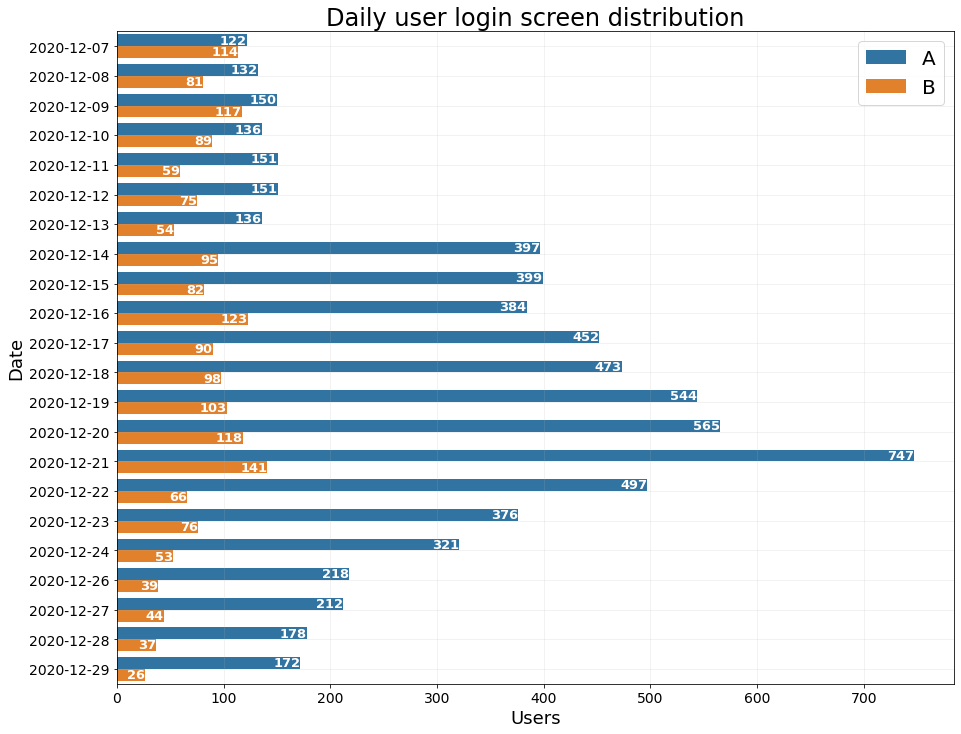

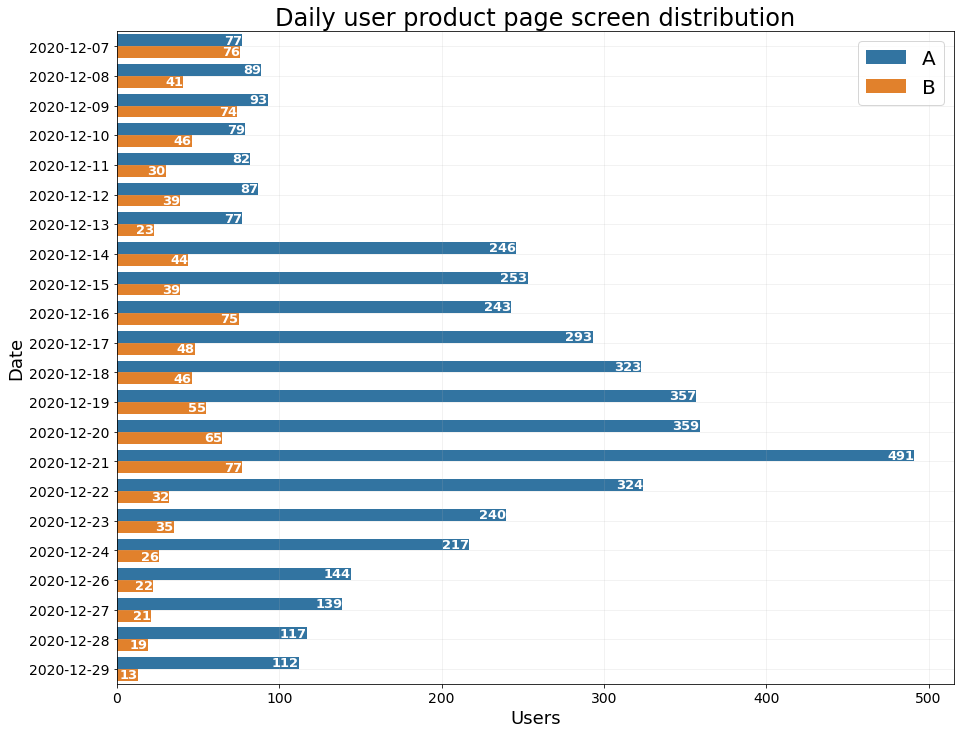

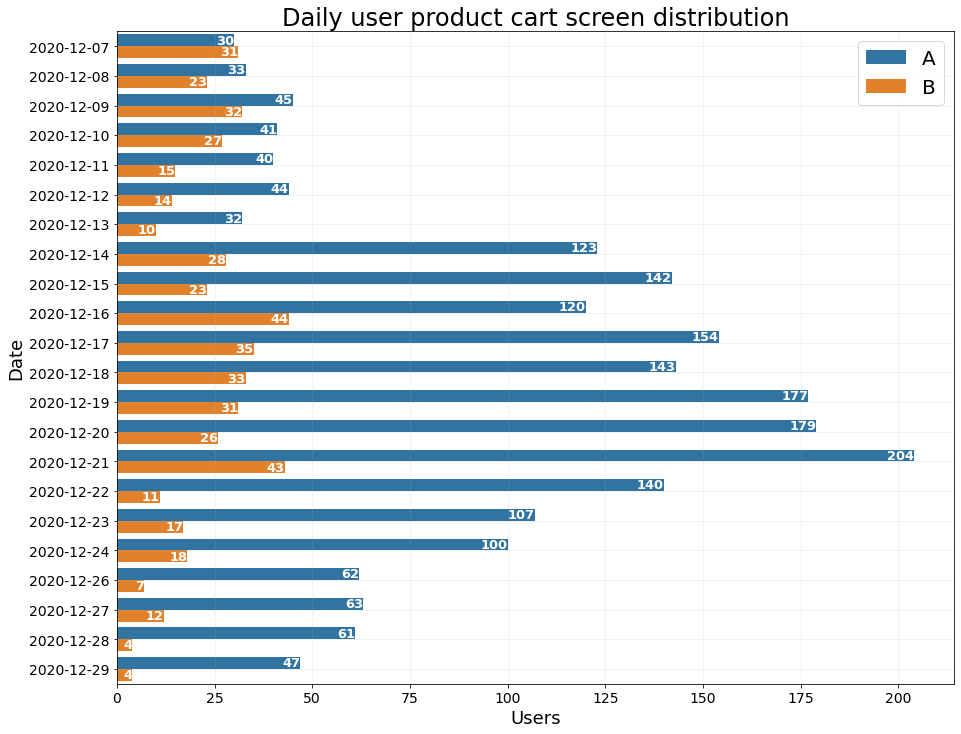

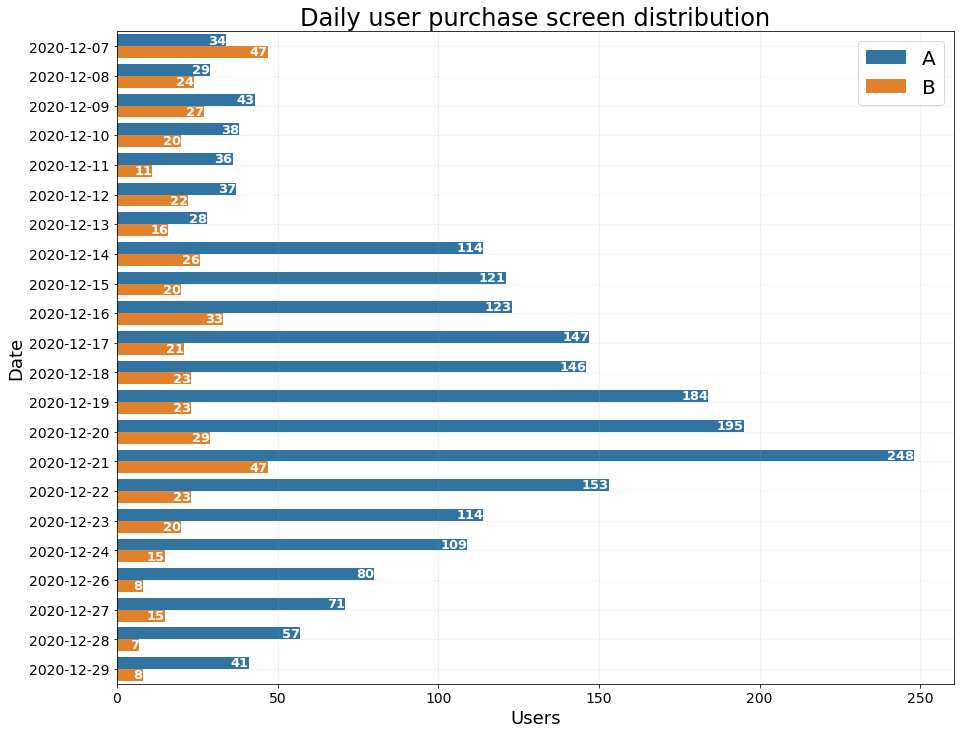

In [54]:
##aggregating data:
redailyvents = (recommend.groupby([recommend['event_dt'].dt.date, 'group','event_name']).agg({'user_id' : 'nunique'}).reset_index()
       .sort_values(by = ['event_dt'])).rename(columns = {'event_dt':'date','user_id':'users', 'event_name':'event'})

#creating a loop to draw plots for each event individually:
reorder= redailyvents['event'].unique().tolist() #make into a list
reorder.sort(key = lambda x: {'login': 0, 'product_page': 1, 'product_cart': 2, 'purchase': 3}[x]) #reorder events to show right
#plot loop:
for event_ in reorder:
    plt.figure(figsize = (15,12))
    plot = sns.barplot(data = redailyvents.query('event == @event_'), x = 'users', y = 'date', hue = 'group')
    plot.tick_params(axis='both', which='major', labelsize=14)
    for bar in plot.patches:
        plt.text((bar.get_width()), bar.get_y() + (bar.get_height() / 2), '{}'.format(int(bar.get_width())),
             ha='right', va='center', fontsize = 13, c = 'w', weight = 'bold')
    plot.set_title('Daily user '+str(event_).replace('_', ' ')+' screen distribution', size = 24)
    plot.set_ylabel('Date', size = 18)
    plot.set_xlabel('Users', size = 18)
    plot.grid(alpha = 0.2)
    plot.legend(fontsize=20)
    plt.show()

##### There are very few users in group B to test upon - especially at the last couple of days.
- In any given day, the most users who made a purchase is 47 on group B. Where on group A the minimum number of users is 28 but the maximum is 248.
- The least number of users who made a purchase in group B is 7. there are 9 days in the test period with less than 20 users making a purchase on group B.
- The proportion of different events per day is similar between the events.
- We already know that the first and last week has much fewer user activity than the middle of the period.
- After login many users are lost (group B has 45% loss, and A has 34%).
- **The most important fact**: Group B actually has lower conversion rate on each step in the funnel than group A.<br>The whole point of the test was to see if the recommendation system can get 10% better conversion.<br>   Quick! back to the drawing board, find a better plan.

<a id="recstatis"></a>
[Back to table of contents](#table) 

[Back to Recommender analysis](#recanal)

---

## is the difference between the groups statistically significant?

<font size="3">**H₀: There is no significant statistical difference between the events of group A, and B.**<br>
**H₁: There is  a significant statistical difference between the events of group A, and B.**<br></font>
***We will use a z-test with significance level of 0.05:***

In [55]:
#creating a function for the z-test:
def hypotest(group1, group2, event, alpha):
    
    #find successes and trials for the ztest:
    successes1 = revents[revents['event_name'] == event][group1].iloc[0]
    successes2 = revents[revents['event_name'] == event][group2].iloc[0]
    trials1 = recommend[recommend['group'] == group1]['user_id'].nunique()
    trials2 = recommend[recommend['group'] == group2]['user_id'].nunique()

    #find proportion for the groups, then combined groups proportion:
    proportion1 = successes1 / trials1
    proportion2 = successes2 / trials2
    combined_proportion = (successes1 + successes2) / (trials1 + trials2)

    #difference of the proportion between the groups:
    difference = proportion1 - proportion2

    #test:
    z_value = difference / mth.sqrt(combined_proportion * (1 - combined_proportion) * (1 / trials1 + 1 / trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    #printing results (rounding pvalue decimal to 10 numbers to rid of scientific notations):
    print(event, ':\np-value: {:.10f}.'.format(p_value))
    if (p_value < alpha):
        print('Reject H₀ on the {} event screen, between groups {} and {}.\n - There is a significant statistical difference between the groups.\n'.format(event, group1, group2))
    else:
        print('Failed to reject H₀ on the "{}" event screen, between groups {} and {}.\n - There is no significant statistical difference between the groups.\n'.format(event, group1, group2))
    pvalues.append(p_value)

In [56]:
successes1 = revents[revents['event_name'] == 'product_page']['A'].iloc[0]
successes2 = revents[revents['event_name'] == 'product_page']['B'].iloc[0]
trials1 = recommend[recommend['group'] == 'A']['user_id'].nunique()
trials2 = recommend[recommend['group'] == 'B']['user_id'].nunique()

#find proportion for the groups, then combined groups proportion:
proportion1 = successes1 / trials1
proportion2 = successes2 / trials2
combined_proportion = (successes1 + successes2) / (trials1 + trials2)
    
#difference of the proportion between the groups:
difference = proportion1 - proportion2


In [57]:
#creating empty list to store pvalues from test:
pvalues = []

#using the testing function on groups A and B:
realpha = 0.05  #needed in next code too
for i in revents['event_name'].unique():
    hypotest("A", "B", i, realpha)

login :
p-value: 0.0620931379.
Failed to reject H₀ on the "login" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.

product_page :
p-value: 0.0000457020.
Reject H₀ on the product_page event screen, between groups A and B.
 - There is a significant statistical difference between the groups.

product_cart :
p-value: 0.3210354198.
Failed to reject H₀ on the "product_cart" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.

purchase :
p-value: 0.1391055128.
Failed to reject H₀ on the "purchase" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.



<a id="correction"></a>
[Back to table of contents](#table) 

---

### Statistical correction
Since we ran multiple tests, there is a risk of rejecting the null hypothesis when it should not be rejected.
According to the Bonferroni correction method, to avoid this problem an alpha level of 0.0125 (1.25%) should be used instead of the previous 0.05 (5%), since we have carried out 4 tests with alpha level of 0.05.

In [58]:
#creating empty list to store pvalues from test:
pvalues = []

#using the testing function on groups A and B:
realpha = 0.0125  #needed in next code too
for i in revents['event_name'].unique():
    hypotest("A", "B", i, realpha)

login :
p-value: 0.0620931379.
Failed to reject H₀ on the "login" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.

product_page :
p-value: 0.0000457020.
Reject H₀ on the product_page event screen, between groups A and B.
 - There is a significant statistical difference between the groups.

product_cart :
p-value: 0.3210354198.
Failed to reject H₀ on the "product_cart" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.

purchase :
p-value: 0.1391055128.
Failed to reject H₀ on the "purchase" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.



### After correcting the alpha level using the Bonferonni method, There is no significant difference between the groups on any of the events.
- With corrected alpha of 0.0125, it is safe to assume there is no statistical difference between the groups on the following events:
    - **login:** with pvalue of 0.062 a little higher than the alpha level.
    - **product cart:** with pvalue of 0.321, MUCH higher than the alpha level.
    - **purchase:** with pvalue of 0.139, much higher than the alpha level.
- For the **product page** the null hypothesis is rejected with pvalue of 0.00004. Therefore we can accept the fact that there is a statistical significant difference between the groups.

- Even with a corrected alpha level of 0.0125 the results are the same as with the raw alpha of 0.05.

<a id="interpeek"></a>
[Back to table of contents](#table) 

---

## A peak to the interface test
### Daily signup / group percentage

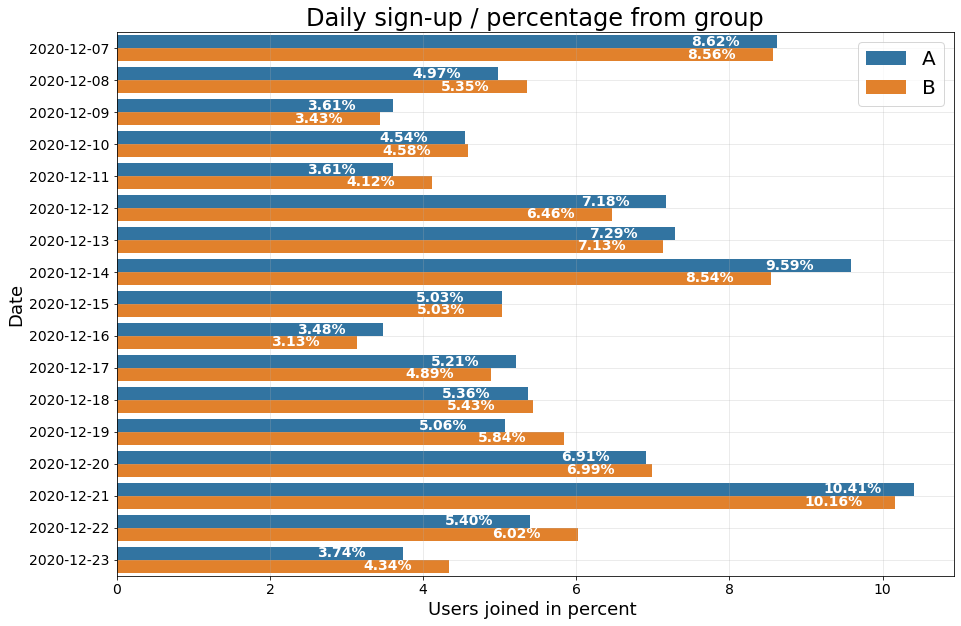

In [59]:
intuspd = interface.groupby(['first_date', 'group'])['user_id'].nunique().reset_index()
intuspd['ratio'] = np.where(intuspd['group'] == 'A', intuspd['user_id'] / intuspd[intuspd['group'] == 'A']['user_id'].sum() * 100,
                                               intuspd['user_id'] / intuspd[intuspd['group'] == 'B']['user_id'].sum() * 100)

plt.figure(figsize = (15,10))
intuspdplot = sns.barplot(data = intuspd, y = 'first_date', x = 'ratio', hue = 'group')
intuspdplot.tick_params(axis='both', which='major', labelsize=14)
intuspdplot.set_yticklabels(intuspd["first_date"].sort_values().map(pd.Timestamp.date).unique())
intuspdplot.set_title('Daily sign-up / percentage from group', size = 24)
intuspdplot.set_ylabel('Date', size = 18)
intuspdplot.set_xlabel('Users joined in percent ', size = 18)
intuspdplot.grid(alpha = 0.3)
intuspdplot.legend(fontsize=20)

for bar in intuspdplot.patches:
    intuspdplot.text((bar.get_width() - 0.8), bar.get_y() + (bar.get_height() / 2), '{:.2f}%'.format(bar.get_width()),
             ha='center', va='center', fontsize = 14, color = 'w', weight = 'bold')

<a id="inteventfun"></a>
[Back to table of contents](#table) 

[Back to peek to interface test](#interpeek)

---

### Events funnel per group

In [60]:
intervents= (interface.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique').reset_index()
         .rename(index= {2:1, 1:2})).sort_index() 

fig = go.Figure()
fig.add_trace(go.Funnel(name = 'Group A', y = intervents['event_name'],
            x = intervents['A'], textinfo = 'value + percent initial', textposition = 'inside'))
#fig.update_yaxes(showticklabels=False)  #hides event names - wanted label inside the bar but it's too small in group B

fig.add_trace(go.Funnel(name = 'Group B', y = intervents['event_name'], 
            x = intervents['B'], textinfo = 'value + percent initial', textposition = 'inside'))

fig.update_layout( title={ 'text': 'User event funnel (in number and % of total user logins)',
                          'y':0.85, 'x':0.5}, yaxis_title='event name', font = dict(size = 18))

fig.show()

<a id="intest"></a>
[Back to table of contents](#table) 

[Back to peek to interface test](#interpeek)

---

### Statistical difference

In [61]:
intervents= (interface.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique').reset_index()
         .rename(index= {2:1, 1:2})).sort_index() 

#creating a function for the z-test:
def hypotest(group1, group2, event, alpha):
    
    #find successes and trials for the ztest:
    successes1 = intervents[intervents.event_name == event][group1].iloc[0]
    successes2 = intervents[intervents.event_name == event][group2].iloc[0]
    trials1 = interface[interface.group == group1]['user_id'].nunique()
    trials2 = interface[interface.group == group2]['user_id'].nunique()

    #find proportion for the groups, then combined groups proportion:
    proportion1 = successes1 / trials1
    proportion2 = successes2 / trials2
    combined_proportion = (successes1 + successes2) / (trials1 + trials2)

    #difference of the proportion between the groups:
    difference = proportion1 - proportion2

    #test:
    z_value = difference / mth.sqrt(combined_proportion * (1 - combined_proportion) * (1 / trials1 + 1 / trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    #printing results (rounding pvalue decimal to 10 numbers to rid of scientific notations):
    print(event, ':\np-value: {:.10f}.'.format(p_value))
    if (p_value < alpha):
        print('Reject H₀ on the {} event screen, between groups {} and {}.\n - There is a significant statistical difference between the groups.\n'.format(event, group1, group2))
    else:
        print('Failed to reject H₀ on the "{}" event screen, between groups {} and {}.\n - There is no significant statistical difference between the groups.\n'.format(event, group1, group2))
    pvalues.append(p_value)

In [62]:
#creating empty list to store pvalues from test:
pvalues = []

#using the testing function on groups A and B:
realpha = 0.05  #needed in next code too
for i in revents['event_name'].unique():
    hypotest("A", "B", i, realpha)

login :
p-value: 0.3360286324.
Failed to reject H₀ on the "login" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.

product_page :
p-value: 0.2227150638.
Failed to reject H₀ on the "product_page" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.

product_cart :
p-value: 0.0535903443.
Failed to reject H₀ on the "product_cart" event screen, between groups A and B.
 - There is no significant statistical difference between the groups.

purchase :
p-value: 0.0198771360.
Reject H₀ on the purchase event screen, between groups A and B.
 - There is a significant statistical difference between the groups.



<a id="intconc"></a>
[Back to table of contents](#table) 

[Back to peek to interface test](#interpeek)

---

### It seems that in the interface test:
- Users were split right. Unlike the recommender test data, every day a similar number (both in numbers and proportion) is recruited.
- The event funnel is split right but:
    - Group B again has a little less conversion (3% less in purchase).
    - a third of the users are lost after login.
- A z-test has shown that there is a significant difference between the groups only in the purchase event.

<a id="whatswrong"></a>
[Back to table of contents](#table) 

---

## So what's wrong?
![what's wrong?](https://i.gifer.com/5ZM.gif "what")



- The test recruited users from Dec-7 to Dec-21, and technically ended at Dec29th (not Jan1st as description implies).<br>Leaving only 8 days to analyze users who joined up late.
- It was expected to recruit 6000 users, in reality, We didn't even reach the 3000 correctly chosen users.
    - Group B had as little as 655 users. spread 655 users on 20 days and you get an average of 32 users a day. very little!
- the daily ratio of recruited users is not the same, this can be problematic because user behaviour can be impacted from day to day by many different reasons (products available, day of week, advertising, etc.)
    - Also, some days of activity had so little users, there was just not enough data to analyse precisely. (have you heard of the law of large numbers?)
- The test was taking place during the biggest holiday season, this is not recommended at all since it has a great impact on user behaviour.
- And for dessert:<br>
    The whole idea of the test was to see if the new system is bringning a 10% increase in the event funnel.<br>
    There was a decrease, and group B had lower conversion than A in all steps of the funnel.

<a id="overallsum"></a>
[Back to table of contents](#table) 

---

# Summary and conclusions

**Data description and processing**
- The data was a big soup of 4 different tables containing 2 different tests.
- It was cleaned of 547 users who were assigned to more than one group (A + A users were spared- they have not seen changes either way).
- Then a new table was merged from the data to form a table only with the users and the information we need for the recommendation system test.
- Since the test is intended to be tested on EU users, 194 more users were removed from the data since they were not from EU.
- Then the region column was removed since all users were of the same value - EU.
- Lastly, on Dec30, only one user has logged in twice. his 2 logs were removed to get a cleaner daily analysis.
- This left us with 2934 users in total, group A with 2279, and group B with 655 users.
    - In expectation, the test needed 6000 users.

---
**User recruitment**
- On the first day of recruitment (Dec-07), group B had 20% users sign ups (group A had 5%).
- Group A had 15% and 14% signups on Dec21st, and Dec14th.
- The ratio of daily signups between the groups is very different. Which may distort the user behaviour analysis, daily recruiting to the groups should be similar in ratio if not in quantities to ensure they are exposed equally to different factors during the test. In our case it wasn't so.
- Most of the users signed up on the second week of the recruitment period.
- There are very few users in group B to test upon - especially at the last couple of days.

---
**User activity and behaviour**
- In the first week of the test, the traffic was low, 122 and 119 users for group A and B, it was gradually growing until Dec21st.
- Dec 21st was the last day of recruiting users. This day also had the highest amount of traffic: in group A 747 users, and in B 141.
- After Dec21st, the traffic was gradually falling again: on Dec29, group B had 26 users actvie and group A had 172
- Android device is used by 44% and 47% of the users of groups A and B. Iphone and PC are about half of it (20% and 26%) and Mac has the smallest share of 9%.

---
**Purchasing**
- A total of 925 out of 2934 users (31.53%) made a purchase at least once.
- Overall, 2633 purchases were made by all users. 
    - In group A: 734 users made a purchase with a 32.21% purchase rate within the group.
    - In group B: 191 users made a purchase with a 29.16% purchase rate within the group.
- Almost ALL users (99.35%) who made a purchase made it on the first day.
    - And then continued purchasing for up to 18 days later.
- It is important to consider that maybe some users stopped purchasing because the test period was over.
---
**Recommendation system test**,
The test was planned as such: (comments bellow)
- Test name: recommender_system_test
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
    - ***Disregarding the 2 events by 1 user on 30th, Dec29 was the last test day.***
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), product cart views (product_card) and purchases (purchase). At each of the stage of the funnel product_page → product_card → purchase, there will be at least a 10% increase.
    - ***There was actually a decrease, and group B had lower conversion than A in all steps of the funnel.***
- Expected number of test participants: 6000
    - ***We didn't even reach the 3000 correctly chosen users.***
---
**Statistical significance in difference between the test groups**
- A z-test was used to check whether the difference.
- With alpha level of 0.05, it was found safe to assume there is no statistical significant difference between the groups for the following events:
    - **login:** with pvalue of 0.062, a little higher than the alpha level.
    - **product cart:** with pvalue of 0.321, MUCH higher than the alpha level.
    - **purchase:** with pvalue of 0.139, much higher than the alpha level.
- For the **product page** the null hypothesis was rejected with pvalue of 0.00004. Therefore we can accept the fact that there is a statistical significant difference between the groups.

---

<img src="https://i.gifer.com/4zuv.gif" alt="Drawing" style="height: 350px;"  align="center"/>

**fun facts**
- Brazil's annual production of watermelons is huge - in recent years approaching 620,000 tons annually. Almost all of Brazil has climate conditions that allow successful cultivation of watermelons, and most watermelon is consumed close to where it was grown.
- In Rio Claro, Brazil, selling watermelons is illegal since 1894 where it was thought to transmit typhus and yellow fever

Maybe it's not a bad idea to move to brazil and start a watermelon farm?  just don't sell them in Rio Claro.




[Back to table of contents](#table) 